In [1]:
#!pip install umap-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap 

data = pd.read_csv("csvs/vectorized_player_moves.csv")
data

,id,player,color,moves
0,0,Alekhine,black,[ 1.29905865e-01 1.01455891e+00 3.73895645e-...
1,1,Alekhine,black,[ 0.18280892 0.9318026 0.55392396 -0.088219...
2,2,Alekhine,white,[ 6.66133687e-02 8.86144698e-01 4.46246237e-...
3,3,Alekhine,white,[-2.47070208e-01 7.47730672e-01 7.05517054e-...
4,4,Alekhine,black,[ 9.70340520e-02 9.53312874e-01 2.98921347e-...
...,...,...,...,...
99799,99892,Zukertort,white,[ 4.91773337e-02 1.13823819e+00 3.32806438e-...
99800,99893,Zukertort,black,[ 1.53048024e-01 8.37615669e-01 4.58987176e-...
99801,99894,Zukertort,white,[-1.47434995e-02 1.29974890e+00 -6.11640140e-...
99802,99895,Zukertort,black,[ 2.50379220e-02 1.04057670e+00 3.39531600e-...


In [3]:
import numpy as np

def parse_embedding(embedding_str):
    return np.fromstring(embedding_str.strip('[]'), sep=' ')

data["moves"] = data["moves"].apply(parse_embedding)

# Ahora puedes convertir a matriz 2D para clustering o visualización
X = np.stack(data["moves"].values)


c:\Users\B\AppData\Local\Programs\Python\Python38\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


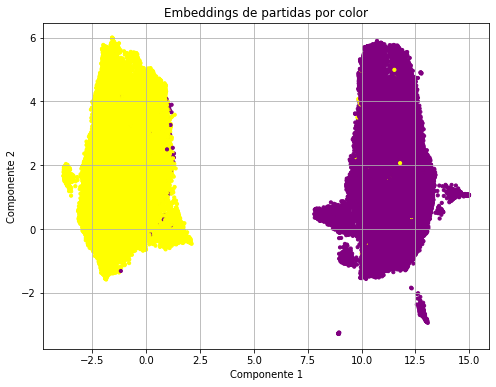

In [4]:
import umap
import matplotlib.pyplot as plt


# Reducir a 2D para visualizar
umap_model = umap.UMAP(n_components=2, random_state=3633)
X_2d = umap_model.fit_transform(X)


# Mapear color: white → gris claro, black → negro
color_map = {"white": "yellow", "black": "purple"}
colors = data["color"].map(color_map)

# Graficar
plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=colors, s=10)
plt.title("Embeddings de partidas por color")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(True)
plt.show()



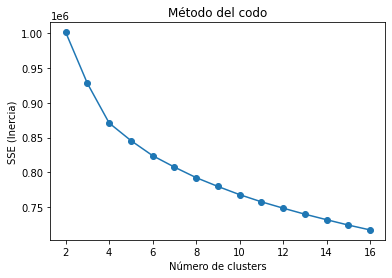

In [6]:
# KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

sse = []
for k in range(2, 17):
    kmeans = KMeans(n_clusters=k, random_state=3633)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.plot(range(2, 17), sse, marker="o")
plt.xlabel("Número de clusters")
plt.ylabel("SSE (Inercia)")
plt.title("Método del codo")
plt.show()

In [10]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def kmeans_player_identification_with_errors_v3(X_train, train_df, X_test, test_df, k_values):
    results = []
    all_errors = []
    accuracies = []

    for k in k_values:
        print(f"\nEvaluando K = {k}...")

        kmeans = KMeans(n_clusters=k, random_state=3633)
        kmeans.fit(X_train)

        # Asignar clusters
        train_df = train_df.copy()
        train_df["cluster"] = kmeans.labels_
        test_labels = kmeans.predict(X_test)
        test_df = test_df.copy()
        test_df["cluster"] = test_labels

        # Distribución de clusters por jugador
        cluster_dist_train = pd.crosstab(train_df["player"], train_df["cluster"], normalize="index")
        cluster_dist_test = pd.crosstab(test_df["player"], test_df["cluster"], normalize="index")

        # Asegurar misma estructura
        cluster_dist_test = cluster_dist_test.reindex(columns=cluster_dist_train.columns, fill_value=0)

        players_train = cluster_dist_train.index.tolist()
        players_test = cluster_dist_test.index.tolist()

        train_vectors = cluster_dist_train.values
        test_vectors = cluster_dist_test.values

        # Comparar vectores
        sim_matrix = cosine_similarity(test_vectors, train_vectors)
        pred_indices = sim_matrix.argmax(axis=1)
        pred_players = [players_train[idx] for idx in pred_indices]

        # Evaluar
        df_compare = pd.DataFrame({
            "player": players_test,
            "pred_player": pred_players
        })
        df_compare["correct"] = df_compare["player"] == df_compare["pred_player"]
        accuracy_global = df_compare["correct"].mean()*100
        accuracies.append(df_compare["correct"].mean())


        print(f"Accuracy para K={k}: {accuracy_global:.2f}%")

        # Mostrar errores
        errors = df_compare[df_compare["correct"] == False].copy()


        # Guardar resultados
        for player, group in df_compare.groupby("player"):
            acc = group["correct"].mean() * 100
            results.append({"k": k, "player": player, "accuracy_%": acc})

        errors["k"] = k
        all_errors.append(errors)

    results_df = pd.DataFrame(results)
    errors_df = pd.concat(all_errors, ignore_index=True)

    return accuracies, results_df, errors_df





In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

# 1. Convertir la columna "moves" a numpy arrays (si no lo están)
# Si tus embeddings están guardados como strings tipo '[0.1, 0.2, ...]', usa ast.literal_eval
import ast

def safe_to_array(x):
    if isinstance(x, str):
        return np.array(ast.literal_eval(x))
    elif isinstance(x, list):
        return np.array(x)
    elif isinstance(x, np.ndarray):
        return x
    else:
        raise ValueError("Formato inesperado en 'moves'")

data["embedding"] = data["moves"].apply(safe_to_array)

# 2. Apilar embeddings en matriz 2D para sklearn
X = np.stack(data["embedding"].values)

# 3. Extraer vector player (labels)
y = data["player"].values

# 4. Separar en train y test, manteniendo proporciones de jugadores (stratify)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3633, stratify=y)

#contras cuantos hay de cada jugador
print(pd.Series(y_test).value_counts())

Kamsky         1407
Carlsen        1323
Caruana        1068
Aronian        1021
Ivanchuk        990
Kramnik         865
Anand           840
Gelfand         794
Timman          723
Karjakin        707
Karpov          706
Portisch        606
Leko            536
Smyslov         524
Topalov         522
Tal             486
Larsen          475
Spassky         446
Geller          439
Kasparov        425
Bronstein       386
Polugaevsky     378
Petrosian       378
Alekhine        332
Najdorf         320
Keres           314
Reshevsky       253
Euwe            224
Korchnoi        207
Bogoljubow      194
Lasker          180
Botvinnik       178
Fischer         165
Rubinstein      159
Maroczy         151
Schlechter      148
Tarrasch        141
Chigorin        137
Anderssen       136
Capablanca      119
Steinitz        118
Nimzowitsch     102
Pillsbury        77
Fine             61
Staunton         56
Zukertort        53
Winawer          48
Morphy           42
Philidor          1
dtype: int64


In [ ]:
# 1. Crear dataframes con la info de train/test, asegurándote que y_train y y_test estén definidos y alineados con X_train y X_test
train_df = pd.DataFrame({"player": y_train})
test_df = pd.DataFrame({"player": y_test})

# 2. Definir la lista de valores K que quieres probar
k_values = list(range(2, 62, 2))
accuracies, df_results, df_errors = kmeans_player_identification_with_errors_v3(X_train, train_df, X_test, test_df, k_values)




Evaluando K = 2...
Accuracy para K=2: 8.16%

Evaluando K = 4...
Accuracy para K=4: 12.24%

Evaluando K = 6...
Accuracy para K=6: 46.94%

Evaluando K = 8...
Accuracy para K=8: 55.10%

Evaluando K = 10...
Accuracy para K=10: 44.90%

Evaluando K = 12...
Accuracy para K=12: 55.10%

Evaluando K = 14...
Accuracy para K=14: 65.31%

Evaluando K = 16...
Accuracy para K=16: 57.14%

Evaluando K = 18...
Accuracy para K=18: 48.98%

Evaluando K = 20...
Accuracy para K=20: 61.22%

Evaluando K = 22...
Accuracy para K=22: 55.10%

Evaluando K = 24...
Accuracy para K=24: 55.10%

Evaluando K = 26...
Accuracy para K=26: 67.35%

Evaluando K = 28...
Accuracy para K=28: 59.18%

Evaluando K = 30...
Accuracy para K=30: 69.39%

Evaluando K = 32...
Accuracy para K=32: 59.18%

Evaluando K = 34...
Accuracy para K=34: 65.31%

Evaluando K = 36...
Accuracy para K=36: 51.02%

Evaluando K = 38...
Accuracy para K=38: 51.02%

Evaluando K = 40...
Accuracy para K=40: 63.27%

Evaluando K = 42...
Accuracy para K=42: 51.02%



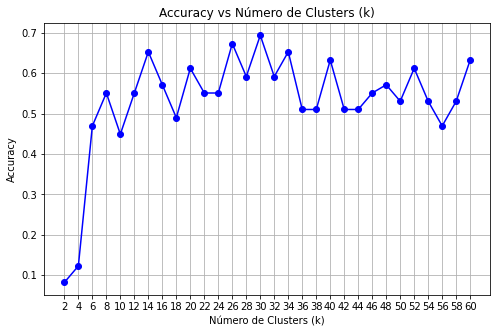

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='blue')
plt.title("Accuracy vs Número de Clusters (k)")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(k_values)
plt.show()

In [14]:
error_counts = df_errors.groupby("player")["correct"].apply(lambda x: (~x).sum()).sort_values(ascending=False)
error_counts

player
Zukertort      30
Tarrasch       30
Nimzowitsch    29
Bogoljubow     29
Staunton       28
Philidor       28
Fine           28
Winawer        27
Capablanca     27
Pillsbury      25
Korchnoi       25
Reshevsky      25
Bronstein      24
Fischer        24
Steinitz       23
Maroczy        22
Petrosian      19
Najdorf        19
Polugaevsky    18
Chigorin       18
Rubinstein     18
Timman         17
Larsen         14
Botvinnik      13
Smyslov        12
Morphy         11
Schlechter     10
Ivanchuk       10
Portisch        9
Lasker          9
Anderssen       7
Tal             7
Spassky         6
Aronian         6
Topalov         6
Gelfand         5
Euwe            4
Geller          3
Karjakin        3
Kasparov        3
Keres           3
Leko            3
Kramnik         2
Carlsen         2
Anand           2
Kamsky          2
Caruana         1
Karpov          1
Alekhine        1
Name: correct, dtype: int64